In [ ]:
import yaml
import sys
import os
import gc
import joblib
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from keras import backend as K
from collections import OrderedDict
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from evml.reliability import compute_calibration, reliability_diagram, reliability_diagrams
from evml.plotting import plot_confusion_matrix, conus_plot

import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
from functools import partial

from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
from hagelslag.evaluation.MetricPlotter import roc_curve, performance_diagram

from imblearn.under_sampling import RandomUnderSampler
from imblearn.tensorflow import balanced_batch_generator

from cartopy import crs as ccrs
from cartopy import feature as cfeature

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

In [2]:
config = "../results/1107/model.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [3]:
def build_model(input_size, 
                hidden_size, 
                num_hidden_layers, 
                output_size, 
                activation, 
                dropout_rate):
    
    model = tf.keras.models.Sequential()
        
    if activation == 'leaky':
        model.add(tf.keras.layers.Dense(input_size))
        model.add(tf.keras.layers.LeakyReLU())
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
            else:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
                model.add(tf.keras.layers.Dropout(dropout_rate))
    else:
        model.add(tf.keras.layers.Dense(input_size, activation=activation))
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
            else:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
                model.add(tf.keras.layers.Dropout(dropout_rate))
      
    model.add(tf.keras.layers.Dense(output_size, activation='linear'))
    
    return model

In [4]:
def Dirichlet(y, output, callback = False, weights = False):
    
    def KL(alpha):
        beta=tf.constant(np.ones((1, alpha.shape[1])), dtype=tf.float32)
        S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
        S_beta = tf.reduce_sum(beta, axis=1, keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - tf.reduce_sum(tf.math.lgamma(alpha), axis=1, keepdims=True)
        lnB_uni = tf.reduce_sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        if weights is not False:
            kl = tf.reduce_sum(weights * (alpha - beta)*(dg1-dg0), axis=1, keepdims=True) + lnB + lnB_uni
        else:
            kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
        return kl
    
    evidence = K.relu(output)
    alpha = evidence + 1
    
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    m = alpha / S

    if weights is not False:
        A = tf.reduce_sum(weights * (y-m)**2, axis=1, keepdims=True)
        B = tf.reduce_sum(weights * alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)
    else:
        A = tf.reduce_sum((y-m)**2, axis=1, keepdims=True)
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)

    annealing_coef = tf.minimum(1.0, callback.this_epoch/callback.annealing_coeff)
    alpha_hat = y + (1-y)*alpha
    C = annealing_coef * KL(alpha_hat)
    C = tf.reduce_mean(C, axis=1)
    return tf.reduce_mean(A + B + C)

In [5]:
def calc_prob_uncertinty(outputs, num_classes = 4):
    evidence = tf.nn.relu(outputs)
    alpha = evidence + 1
    S = tf.keras.backend.sum(alpha, axis=1, keepdims=True)
    u = num_classes / S
    prob = alpha / S
    epistemic = prob * (1 - prob) / (S + 1)
    aleatoric = prob - prob**2 - epistemic
    return prob.numpy(), u.numpy(), aleatoric.numpy(), epistemic.numpy()

In [6]:
class ReportEpoch(tf.keras.callbacks.Callback):
    def __init__(self, annealing_coeff):
        super(ReportEpoch, self).__init__()
        self.this_epoch = 0
        self.annealing_coeff = annealing_coeff
    def on_epoch_begin(self, epoch, logs={}):
        self.this_epoch += 1

In [7]:
if not os.path.isfile(os.path.join(conf['data_path'], "cached.parquet")):
    df = pd.concat([
        pd.read_parquet(x) for x in tqdm.tqdm(glob.glob(os.path.join(conf['data_path'], "*.parquet")))
    ])
    df.to_parquet(os.path.join(conf['data_path'], "cached.parquet"))
else:
    df = pd.read_parquet(os.path.join(conf['data_path'], "cached.parquet"))

### Split and preprocess the data
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])
df["id"] = range(df.shape[0])

texas = [f"2021-02-{k}" for k in range(10, 20)] #texas
new_york = ["2022-02-03", "2022-02-04"] # New York
ne_noreaster = [f"2017-03-{k}" for k in range(11, 18)] # NE NorEaster
dec_ice_storm = [f"2016-12-{k}" for k in range(15, 21)]
test_days = texas + new_york + ne_noreaster + dec_ice_storm
test_days_c = df["day"].isin(test_days)

In [8]:
# Need the same test_data for all trained models (data and model ensembles)
#n_splits = 10
data_seed = 0
flat_seed = 1000
gsp = GroupShuffleSplit(n_splits=conf["trainer"]["n_splits"],
                        random_state = flat_seed, 
                        train_size=conf["trainer"]["train_size1"])
splits = list(gsp.split(df[~test_days_c], groups = df[~test_days_c]["day"]))
train_index, test_index = splits[0]
train_data, test_data = df[~test_days_c].iloc[train_index].copy(), df[~test_days_c].iloc[test_index].copy() 
test_data = pd.concat([test_data, df[test_days_c].copy()])

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=conf["trainer"]["n_splits"],
                        random_state = flat_seed, 
                        train_size=conf["trainer"]["train_size2"])
splits = list(gsp.split(train_data, groups = train_data["day"]))

train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy() 

In [9]:
#test_data.to_csv(os.path.join(conf["save_loc"], "test_df.csv"))

In [10]:
features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
outputs = conf['outputvars']
num_classes = len(outputs)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[features])
x_valid = scaler_x.transform(valid_data[features])
x_test = scaler_x.transform(test_data[features])
y_train = tf.keras.utils.to_categorical(np.argmax(train_data[outputs].to_numpy(), 1), num_classes)
y_valid = tf.keras.utils.to_categorical(np.argmax(valid_data[outputs].to_numpy(), 1), num_classes)
y_test = tf.keras.utils.to_categorical(np.argmax(test_data[outputs].to_numpy(), 1), num_classes)

In [11]:
with open(os.path.join(conf["save_loc"], "scalers.pkl"), "wb") as fid: 
    joblib.dump(scaler_x, fid) 

In [12]:
train_idx = np.argmax(train_data[outputs].to_numpy(), 1)

# weights = sklearn.utils.class_weight.compute_class_weight(
#             class_weight = 'balanced',
#             classes = np.unique(train_idx), 
#             y = train_idx)

In [13]:
#weights = np.array([ 0.37939381,  0.96543804,  35.0 , 15.0])
weights = conf["trainer"]["outputvar_weights"]

In [14]:
training_generator, steps_per_epoch = balanced_batch_generator(
    x_train,
    y_train,
    sample_weight=np.array([weights[l] for l in train_idx]),
    sampler=RandomUnderSampler(),
    batch_size=conf["trainer"]["batch_size"],
    random_state=flat_seed,
)

In [15]:
try:
    del mlp
    K.clear_session()
    gc.collect()
except:
    pass

In [16]:
mlp = build_model(len(features), 
                  conf["trainer"]["hidden_sizes"], 
                  conf["trainer"]["num_hidden_layers"], 
                  len(outputs), 
                  conf["trainer"]["activation"], 
                  conf["trainer"]["dropout_rate"])

mlp.build((conf["trainer"]["batch_size"], len(features)))
mlp.summary()

#mlp = MLP(hidden_size, dropout, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1289, 268)               72092     
                                                                 
 dense_1 (Dense)             (1289, 541)               145529    
                                                                 
 dropout (Dropout)           (1289, 541)               0         
                                                                 
 dense_2 (Dense)             (1289, 541)               293222    
                                                                 
 dropout_1 (Dropout)         (1289, 541)               0         
                                                                 
 dense_3 (Dense)             (1289, 541)               293222    
                                                                 
 dropout_2 (Dropout)         (1289, 541)               0

2022-11-07 11:15:54.970366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 11:15:55.516926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30976 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


In [17]:
#mlp.load_weights(os.path.join(conf["save_loc"], "best.pt"))

In [18]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=conf["trainer"]["learning_rate"]
)

In [19]:
annealing_coeff = 50
epoch_callback = ReportEpoch(annealing_coeff)
#weights = np.array(conf["trainer"]["outputvar_weights"])
#weights /= weights.sum()

criterion = partial(
    Dirichlet,
    callback = epoch_callback, 
    weights = False
)

# compile model
mlp.compile(
    optimizer = optimizer, 
    loss = criterion,
    metrics = ["accuracy",
               tf.keras.metrics.Precision(name="prec"),
               tf.keras.metrics.Recall(name="recall"),
               tfa.metrics.F1Score(num_classes=num_classes,
                                   average='macro', name="f1"),
               tf.keras.metrics.AUC(name = "auc")]
    #run_eagerly=True
)

In [20]:
# create early stopping callback
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_f1', 
    mode = 'max',
    patience = 15,
    restore_best_weights = True
)

# create reduce LR callback
callback2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_f1', 
    factor = 0.1, 
    patience = 3, 
    verbose = 0,
    mode = 'max',
    min_lr = 1e-7
)

In [21]:
# fit model to training data
#sample_weight = np.array([weights[l] for l in train_idx])

history = mlp.fit(
    training_generator, 
    steps_per_epoch=steps_per_epoch,
#     x = x_train, 
#     y = y_train,
#     sample_weight = sample_weight,
#     batch_size = conf["trainer"]["batch_size"],
    validation_data = (x_valid, y_valid),
    epochs = conf["trainer"]["epochs"],
    callbacks = [epoch_callback, callback1, callback2],
    verbose = 1,
    shuffle = True
)

Epoch 1/1000
22/22 [==============================] - 7s 199ms/step - loss: 23.6349 - accuracy: 0.5693 - prec: 0.3917 - recall: 0.8557 - f1: 0.5597 - auc: 0.7177 - val_loss: 0.3325 - val_accuracy: 0.7836 - val_prec: 0.5244 - val_recall: 0.8910 - val_f1: 0.5861 - val_auc: 0.8197 - lr: 8.7078e-04
Epoch 2/1000
22/22 [==============================] - 4s 174ms/step - loss: 20.0635 - accuracy: 0.6522 - prec: 0.4421 - recall: 0.8933 - f1: 0.6517 - auc: 0.7685 - val_loss: 0.3074 - val_accuracy: 0.8026 - val_prec: 0.6543 - val_recall: 0.8792 - val_f1: 0.6053 - val_auc: 0.8678 - lr: 8.7078e-04
Epoch 3/1000
22/22 [==============================] - 4s 173ms/step - loss: 19.0313 - accuracy: 0.6745 - prec: 0.4622 - recall: 0.8957 - f1: 0.6737 - auc: 0.7839 - val_loss: 0.3545 - val_accuracy: 0.7704 - val_prec: 0.6240 - val_recall: 0.8688 - val_f1: 0.5751 - val_auc: 0.8530 - lr: 8.7078e-04
Epoch 4/1000
22/22 [==============================] - 4s 173ms/step - loss: 18.8249 - accuracy: 0.6799 - prec: 0

In [22]:
mlp.save_weights(os.path.join(conf["save_loc"], "best.pt"))

In [23]:
preds = mlp.predict(x_test)

1422/1422 [==============================] - 2s 1ms/step


In [24]:
prob, u, aleatoric, epistemic = calc_prob_uncertinty(preds)

In [25]:
true_labels = np.argmax(test_data[outputs].to_numpy(), 1)
pred_labels = np.argmax(prob, 1)
confidences = np.take_along_axis(
    prob,
    pred_labels[:, None], 
    axis=1
)
ale = np.take_along_axis(
    aleatoric,
    pred_labels[:, None], 
    axis=1
)
epi = np.take_along_axis(
    epistemic,
    pred_labels[:, None], 
    axis=1
)

test_data["true_label"] = true_labels
test_data["pred_label"] = pred_labels
test_data["pred_conf"] = confidences
test_data["pred_sigma"] = u
test_data["pred_ale"] = ale
test_data["pred_epi"] = epi
test_data["accuracy"] = (test_data["pred_label"] == test_data["true_label"]).to_numpy()

In [26]:
match = (pred_labels == true_labels).astype(float)
acc = np.mean(match)
evidence = np.where(preds > 0, preds, 0.0) #relu_evidence(outputs)
alpha = evidence + 1
u = num_classes / np.sum(alpha, axis=1, keepdims=True)
prob = alpha / np.sum(alpha, axis=1, keepdims=True)

total_evidence = np.sum(evidence, axis=1, keepdims=True)
mean_evidence = np.mean(total_evidence)
mean_evidence_succ = np.sum(
    np.sum(evidence, axis=1, keepdims=True) * match
) / np.sum(match + 1e-20)
mean_evidence_fail = np.sum(
    np.sum(evidence, axis=1, keepdims=True) * (1 - match)
) / (np.sum(np.abs(1 - match)) + 1e-20)

In [27]:
# def draw_EDL_results(K, train_acc1, train_ev_s, train_ev_f): 
#     # calculate uncertainty for training and testing data for correctly and misclassified samples
#     train_u_succ = K / (K+np.array(train_ev_s))
#     train_u_fail = K / (K+np.array(train_ev_f))
#     #test_u_succ  = K / (K+np.array(test_ev_s))
#     #test_u_fail  = K / (K+np.array(test_ev_f))
    
#     f, axs = plt.subplots(2, 2)
#     f.set_size_inches([10,10])
    
#     axs[0,0].plot(train_ev_s,c='r',marker='+')
#     axs[0,0].plot(train_ev_f,c='k',marker='x')
#     axs[0,0].set_title('Train Data')
#     axs[0,0].set_xlabel('Epoch')
#     axs[0,0].set_ylabel('Estimated total evidence for classification') 
#     axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
#     axs[0,1].plot(train_u_succ,c='r',marker='+')
#     axs[0,1].plot(train_u_fail,c='k',marker='x')
#     axs[0,1].plot(train_acc1,c='blue',marker='*')
#     axs[0,1].set_title('Train Data')
#     axs[0,1].set_xlabel('Epoch')
#     axs[0,1].set_ylabel('Estimated uncertainty for classification')
#     axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
# #     axs[1,0].plot(test_ev_s,c='r',marker='+')
# #     axs[1,0].plot(test_ev_f,c='k',marker='x')
# #     axs[1,0].set_title('Test Data')
# #     axs[1,0].set_xlabel('Epoch')
# #     axs[1,0].set_ylabel('Estimated total evidence for classification') 
# #     axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
# #     axs[1,1].plot(test_u_succ,c='r',marker='+')
# #     axs[1,1].plot(test_u_fail,c='k',marker='x')
# #     axs[1,1].plot(test_acc1,c='blue',marker='*')
# #     axs[1,1].set_title('Test Data')
# #     axs[1,1].set_xlabel('Epoch')
# #     axs[1,1].set_ylabel('Estimated uncertainty for classification')
# #     axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
#     plt.show()


In [28]:
# draw_EDL_results(
#     4, acc, mean_evidence_succ, mean_evidence_fail
# )

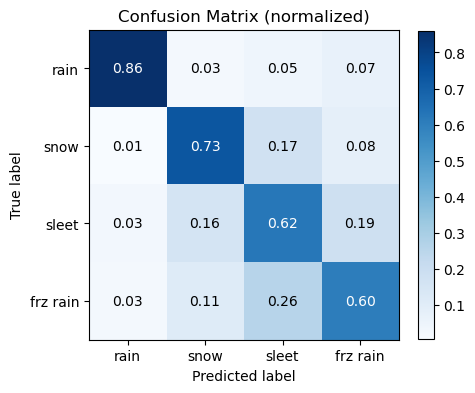

In [86]:
plot_confusion_matrix(test_data["true_label"], 
                      test_data["pred_label"], 
                      ["rain", "snow", "sleet", "frz rain"], 
                      "MLP", 
                      normalize=True,
                      title=f'Confusion Matrix (normalized)')#, filename='cm_norm.png')

plt.show()

In [30]:
rocs = []
for i in range(4):
    forecasts = test_data['pred_conf']
    obs = np.where(test_data['true_label'] == i, 1, 0)
    roc = DistributedROC(thresholds=np.arange(0.0, 1.01, 0.01),
                         obs_threshold=0.5)
    roc.update(forecasts, obs)
    rocs.append(roc)

roc_curve(rocs,
          ["rain", "snow", "sleet", "frz rain"], 
          ["blue", "grey", "red", "purple"], 
          ["s", "o", "v", "^"],
          os.path.join(conf["save_loc"], "roc_curve_evidential.png"))
    
performance_diagram(rocs, 
                    ["rain", "snow", "sleet", "frz rain"], 
                    ["blue", "grey", "red", "purple"], 
                    ["s", "o", "v", "^"],
                    os.path.join(conf["save_loc"], "performance_evidential.png"))

/glade/work/schreck/py37/lib/python3.7/site-packages/hagelslag/evaluation/MetricPlotter.py:132: RuntimeWarning: divide by zero encountered in true_divide
  bias = pod_g / sr_g
/glade/work/schreck/py37/lib/python3.7/site-packages/hagelslag/evaluation/MetricPlotter.py:132: RuntimeWarning: invalid value encountered in true_divide
  bias = pod_g / sr_g
/glade/work/schreck/py37/lib/python3.7/site-packages/hagelslag/evaluation/MetricPlotter.py:133: RuntimeWarning: divide by zero encountered in true_divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


In [31]:
results_calibration = compute_calibration(
    true_labels, 
    pred_labels, 
    confidences, 
    num_bins=10)

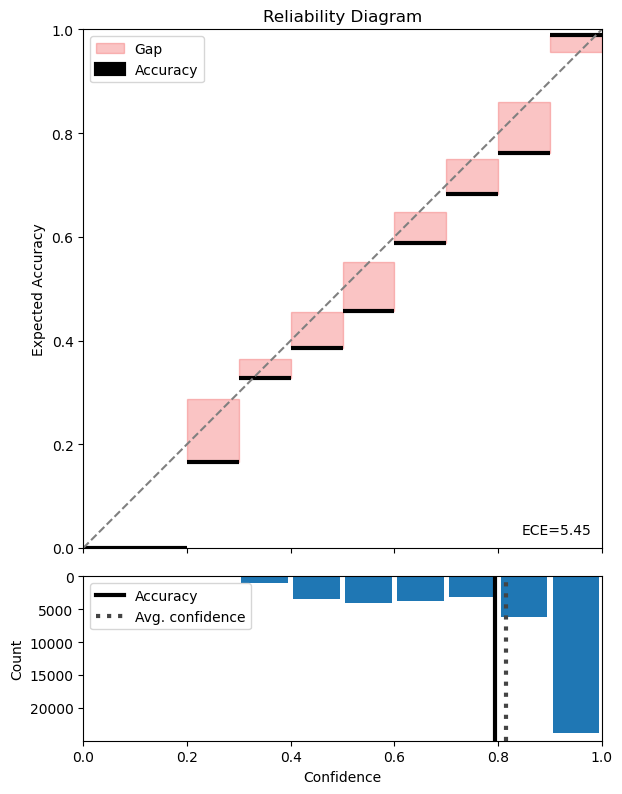

In [32]:
reliability_diagram(
    true_labels, 
    pred_labels, 
    confidences, 
    num_bins=10, dpi=100)

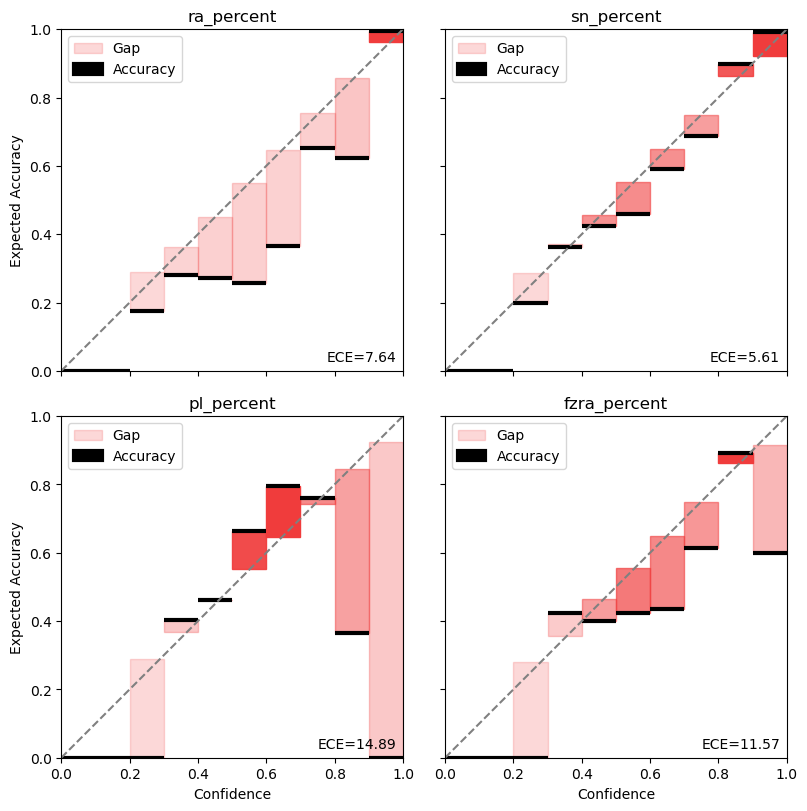

In [33]:
results = OrderedDict()
for label in range(num_classes):
    cond = (test_data["true_label"] == label)
    results[outputs[label]] = {
        "true_labels": test_data[cond]["true_label"].values, 
        "pred_labels": test_data[cond]["pred_label"].values, 
        "confidences": test_data[cond]["pred_conf"].values
    }
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha",
                           num_cols=2, dpi=100, return_fig=True)

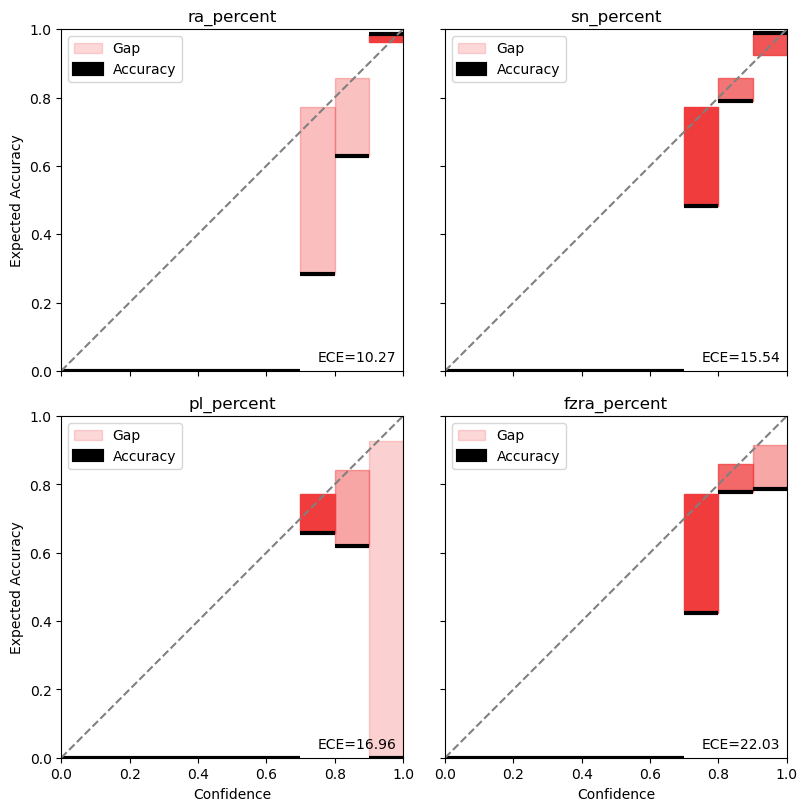

In [34]:
results = OrderedDict()
for label in range(num_classes):
    cond = (test_data["true_label"] == label)
    results[outputs[label]] = {
        "true_labels": test_data[cond]["true_label"].values, 
        "pred_labels": test_data[cond]["pred_label"].values, 
        "confidences": 1.0-test_data[cond]["pred_ale"].values
    }
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha",
                           num_cols=2, dpi=100, return_fig=True)

In [35]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

In [36]:
colors = ["g", "b", "r", "k"]

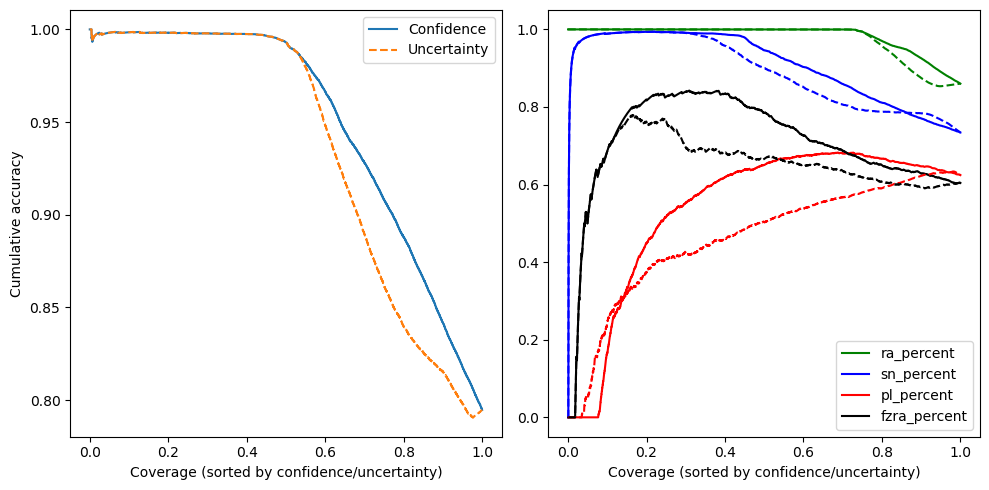

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey='col')
    
_test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "accuracy")
ax1.plot(
    _test_data_sorted["pred_conf_cov"],
    _test_data_sorted["cu_accuracy"]
)
    

for label in range(num_classes):
    cond = (test_data["true_label"] == label)
    _test_data_sorted = compute_cov(test_data[cond], col = "pred_conf", quan = "accuracy")
    ax2.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_accuracy"], c = colors[label]
    )
    
#plt.show()

_test_data_sorted = compute_cov(test_data, col = "pred_sigma", quan = "accuracy", ascending = True)
ax1.plot(
        _test_data_sorted["pred_sigma_cov"],
        _test_data_sorted["cu_accuracy"], ls = "--"
    )
for label in range(num_classes):
    c = (test_data["true_label"] == label)    
    _test_data_sorted = compute_cov(test_data[c], col = "pred_sigma", quan = "accuracy", ascending = True)
    ax2.plot(
        _test_data_sorted["pred_sigma_cov"],
        _test_data_sorted["cu_accuracy"], c = colors[label], ls = "--"
    )
    
ax1.set_ylabel("Cumulative accuracy")
ax1.set_xlabel("Coverage (sorted by confidence/uncertainty)")
ax2.set_xlabel("Coverage (sorted by confidence/uncertainty)")
ax1.legend(["Confidence", "Uncertainty"], loc = "best")
ax2.legend(outputs, loc = "best")
plt.tight_layout()

In [38]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey='col')

# _test_data_sorted = compute_cov(test_data, col = "pred_sigma", quan = "accuracy", ascending = True)
# ax1.plot(
#         _test_data_sorted["pred_sigma_cov"],
#         _test_data_sorted["cu_accuracy"]
#     )
# for label in range(num_classes):
#     c = (test_data["true_label"] == label)    
#     _test_data_sorted = compute_cov(test_data[c], col = "pred_sigma", quan = "accuracy", ascending = True)
#     ax1.plot(
#         _test_data_sorted["pred_sigma_cov"],
#         _test_data_sorted["cu_accuracy"], c = colors[label], 
#     )
    
# ax[0].set_ylabel("Cumulative accuracy")
# ax[0].set_xlabel("Test data fraction (sorted by pred sigma)")
# ax[1].set_xlabel("Test data fraction (sorted by pred sigma)")

# plt.show()

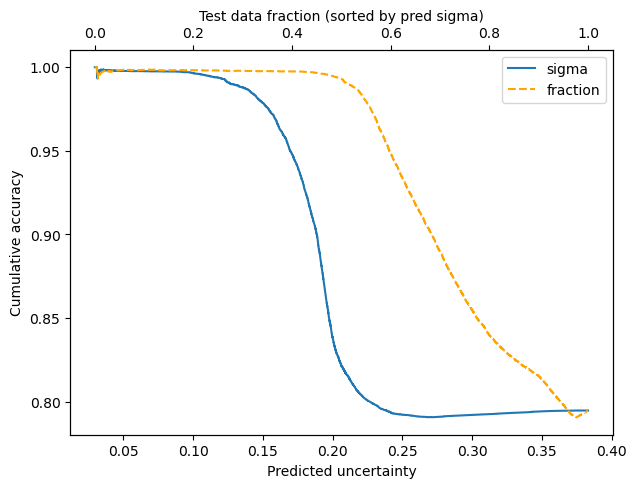

In [39]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

test_data_sorted = compute_cov(test_data, col = "pred_sigma", quan = "accuracy", ascending = True)

l1, = ax.plot(
    test_data_sorted["pred_sigma"],
    test_data_sorted["cu_accuracy"],
    label = "sigma"
)

ax2 = ax.twiny()
l2, = ax2.plot(
    test_data_sorted["pred_sigma_cov"],
    test_data_sorted["cu_accuracy"], 
    color='orange', ls = "--", 
    label = "fraction")

ax.set_ylabel("Cumulative accuracy")
ax2.set_xlabel("Test data fraction (sorted by pred sigma)")
ax.set_xlabel("Predicted uncertainty")

plt.legend([l1, l2], ["sigma", "fraction"])

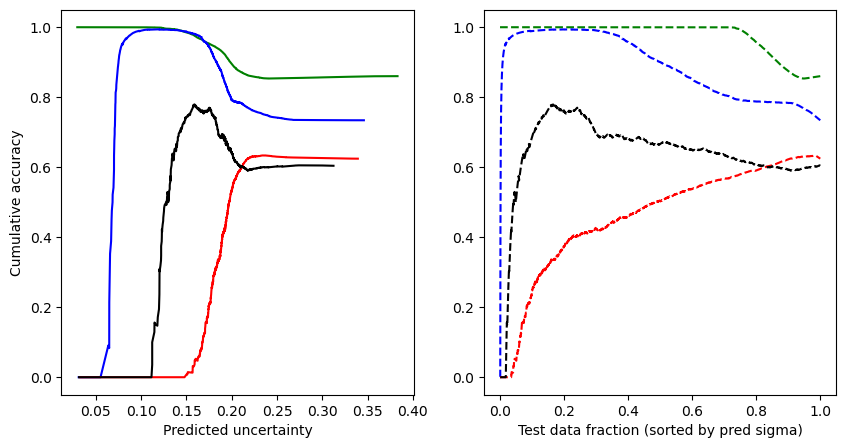

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey='col')

for label in range(num_classes):
    c = (test_data["true_label"] == label)
    _test_data_sorted = compute_cov(test_data[c], col = "pred_sigma", quan = "accuracy", ascending = True)
    ax[0].plot(
        _test_data_sorted["pred_sigma"],
        _test_data_sorted["cu_accuracy"], c = colors[label]
    )
    _test_data_sorted = compute_cov(test_data[c], col = "pred_sigma", quan = "accuracy", ascending = True)
    ax[1].plot(
        _test_data_sorted["pred_sigma_cov"],
        _test_data_sorted["cu_accuracy"], c = colors[label], 
        ls = "--"
    )
    
ax[0].set_ylabel("Cumulative accuracy")
#ax[0].set_xlabel("Coverage (sorted by predicted uncertainty)")

ax[1].set_xlabel("Test data fraction (sorted by pred sigma)")
ax[0].set_xlabel("Predicted uncertainty")


plt.show()

In [41]:
ne_noreaster

['2017-03-11',
 '2017-03-12',
 '2017-03-13',
 '2017-03-14',
 '2017-03-15',
 '2017-03-16',
 '2017-03-17']

/glade/work/schreck/py37/lib/python3.7/site-packages/evml/plotting.py:96: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


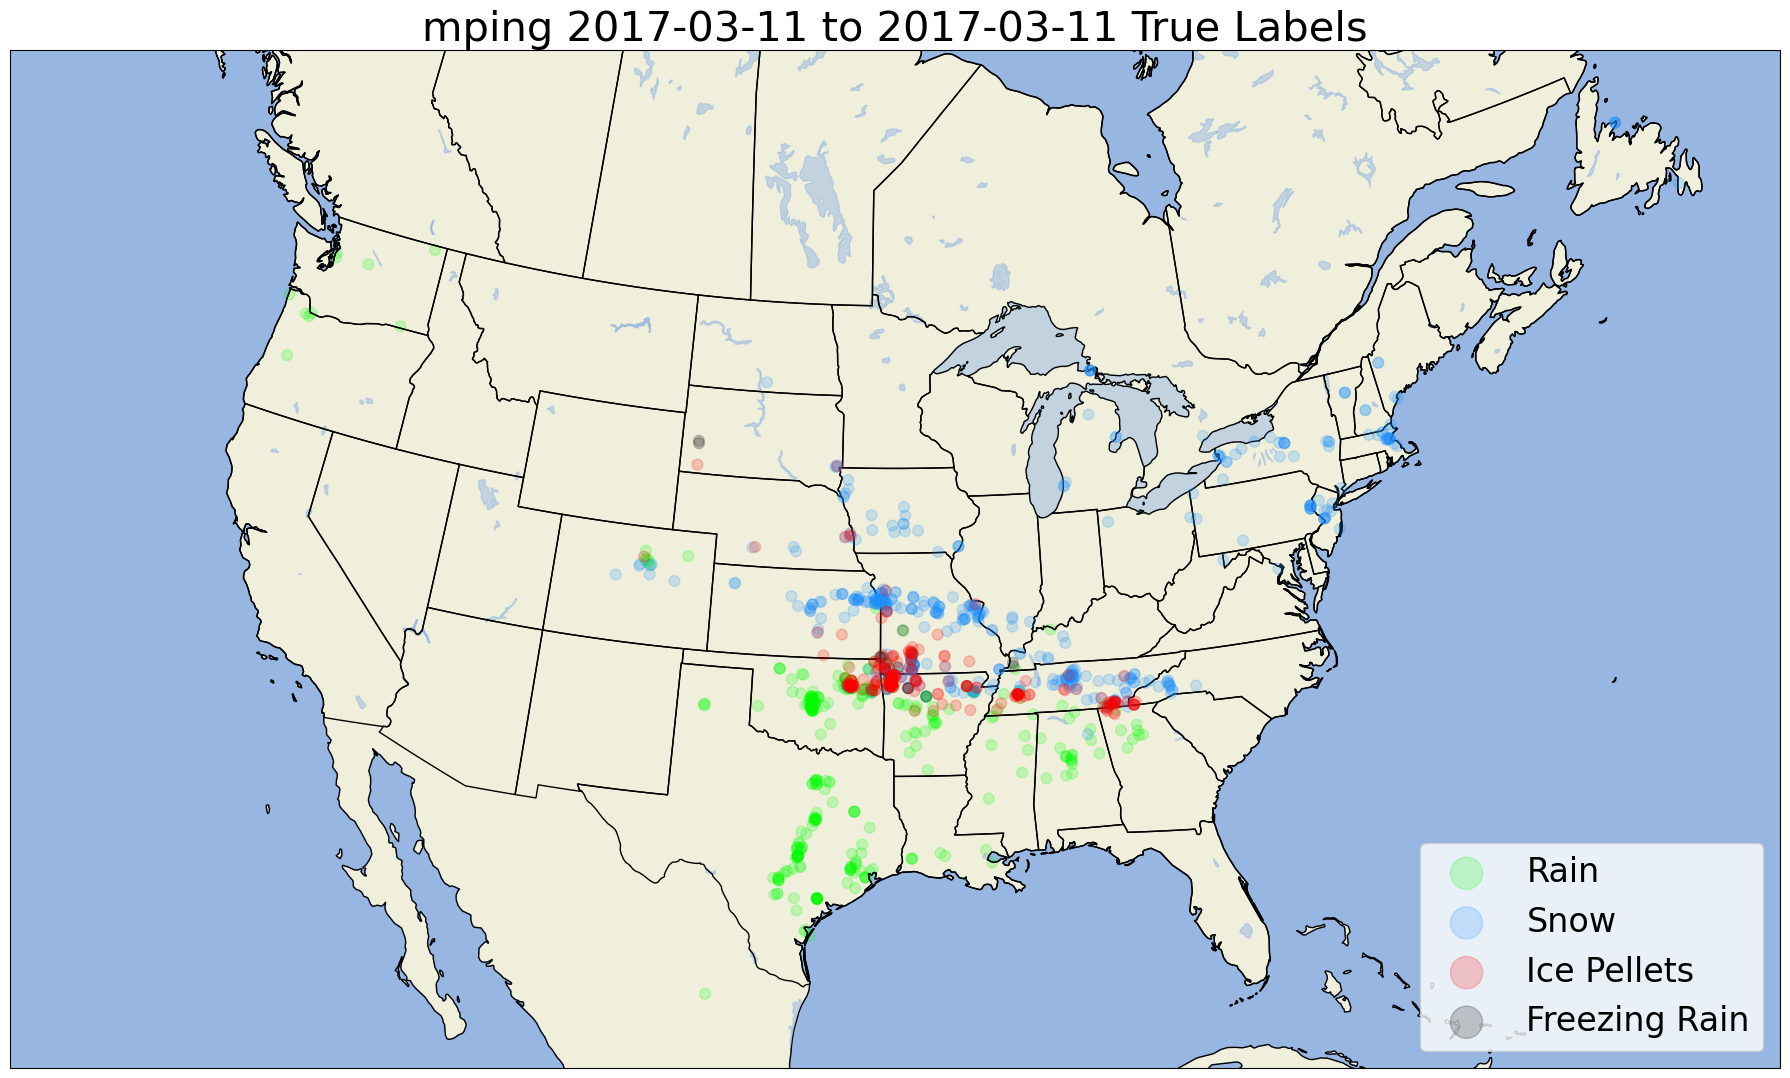

/glade/work/schreck/py37/lib/python3.7/site-packages/evml/plotting.py:96: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


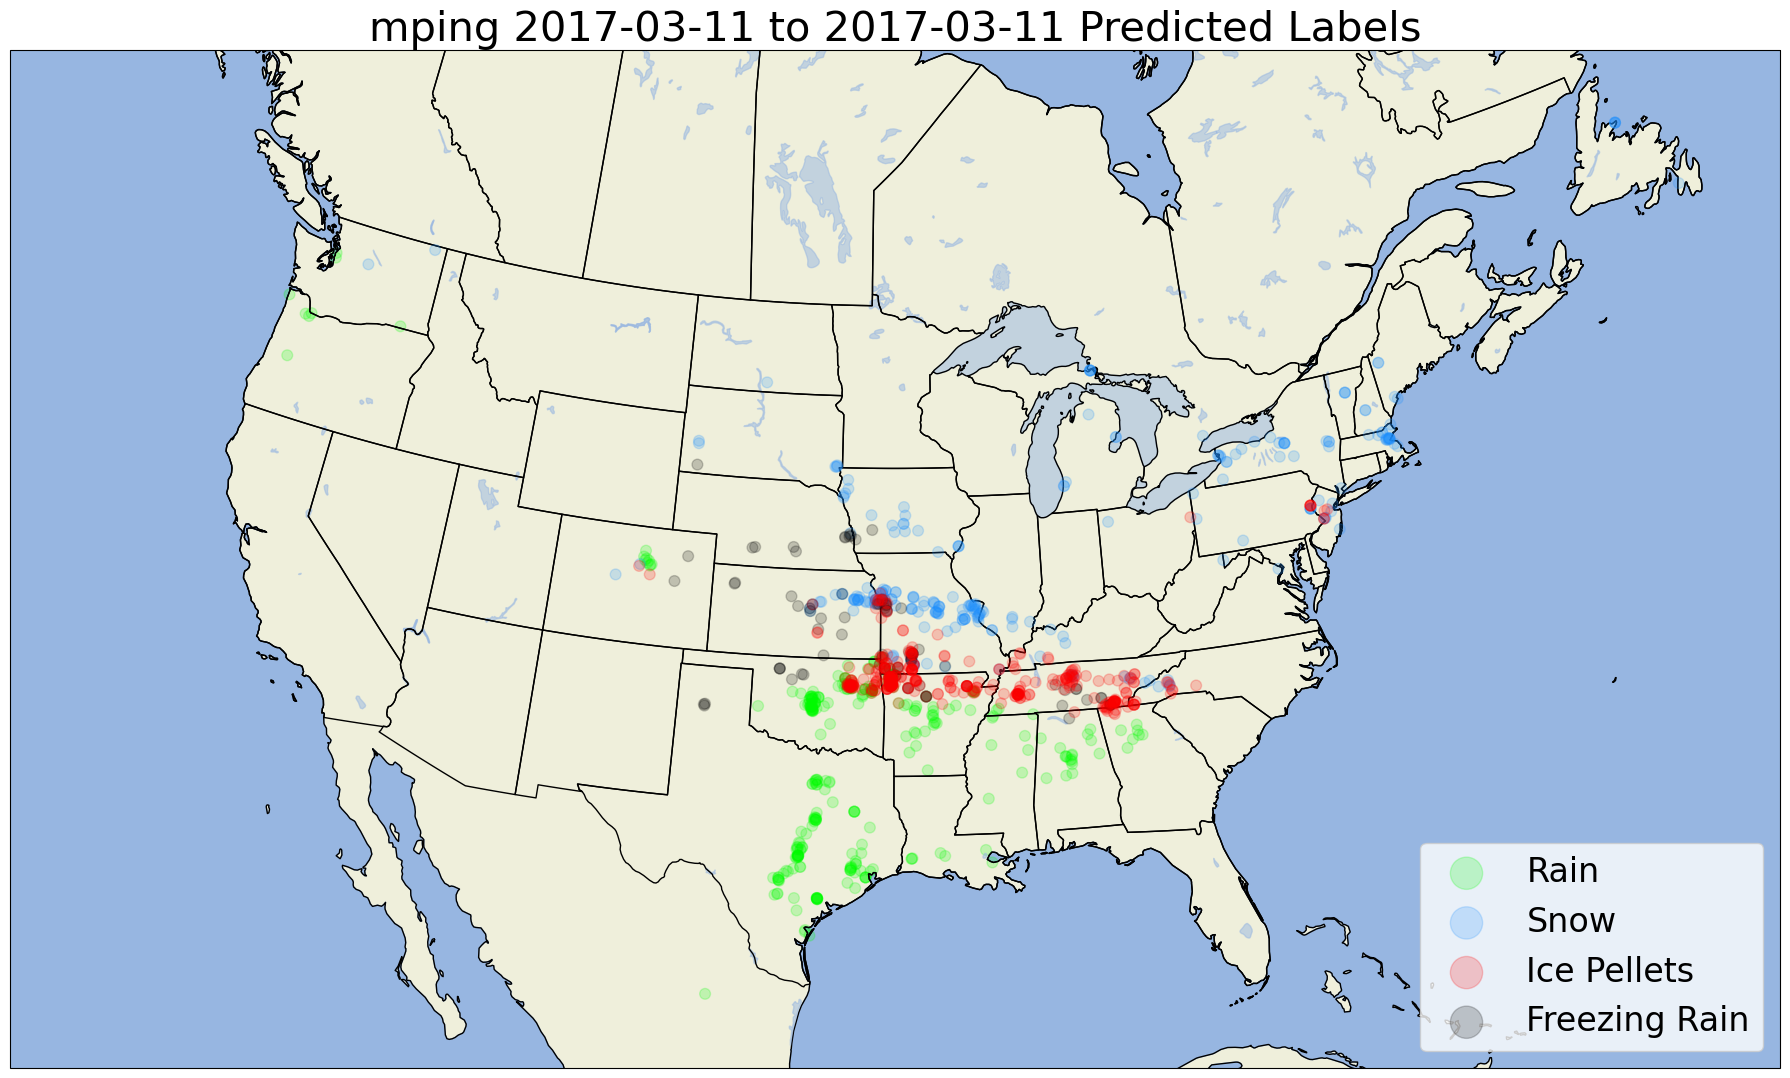

In [42]:
conus_plot(
    test_data[test_data["day"].isin(ne_noreaster[0:1])], 
    column = 'true_label', 
    title = "True"
)

conus_plot(
    test_data[test_data["day"].isin(ne_noreaster[0:1])], 
    column = 'pred_label', 
    title = "Predicted"
)

In [43]:
def conf_sigma_plots(df, col = "pred_conf", label = "Confidence"):
    latN = 50.0
    latS = 23.0
    lonW = -74.0
    lonE = -120.0
    cLat = (latN + latS)/2
    cLon = (lonW + lonE )/2
    colors = {0:'lime', 1:'dodgerblue', 2:'red', 3:'black'}
    proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
    res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1, projection=proj)
    ax.set_extent([lonW, lonE, latS, latN])
    ax.add_feature(cfeature.LAND.with_scale(res))
    ax.add_feature(cfeature.OCEAN.with_scale(res))
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
    ax.add_feature(cfeature.STATES.with_scale(res))

    df['rand_lon'] = [df['lon'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lon']))]
    df['rand_lat'] = [df['lat'].to_numpy()[i]+np.random.normal(scale=scale) for i in range(len(df['lat']))]
    zorder = [1,2,4,3]

    for i in range(4):
        sc = ax.scatter(df["rand_lon"][df["pred_label"] == i]-360,
                   df["rand_lat"][df["pred_label"] == i],
                   c=df[col][df["pred_label"] == i],
                   s=3, transform=ccrs.PlateCarree(), cmap='Spectral', 
                   vmin=0, vmax=df[col].max())

    cbar = plt.colorbar(sc, orientation="horizontal", pad=0.025, shrink=0.9325)
    cbar.set_label(label, size=12)
    #plt.title(f"{dataset} Precipitation Type {first_day} to {last_day} Confidences", fontsize=20)
    # plt.savefig(f'{image_path}{timeframe}_conf.png', dpi=300, bbox_inches='tight')
    plt.show()

In [44]:
#conf_sigma_plots(test_data)

In [75]:
def labels_video(
    test_data, 
    case,
    dataset = "mping",
    column = "pred_label", 
    title = "Predicted", 
    save_path = False):
    
    latN = 50.0
    latS = 23.0
    lonW = -74.0
    lonE = -120.0
    cLat = (latN + latS)/2
    cLon = (lonW + lonE )/2
    colors = {0:'lime', 1:'dodgerblue', 2:'red', 3:'black'}
    proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
    res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1, projection=proj)
    ax.set_extent([lonW, lonE, latS, latN])
    ax.add_feature(cfeature.LAND.with_scale(res))
    ax.add_feature(cfeature.OCEAN.with_scale(res))
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
    ax.add_feature(cfeature.STATES.with_scale(res))

    zorder = [1,2,4,3]
    def update(k):
        #fig = plt.figure(figsize=(12, 8))
        ax.cla()
        ax.set_extent([lonW, lonE, latS, latN])
        ax.add_feature(cfeature.LAND.with_scale(res))
        ax.add_feature(cfeature.OCEAN.with_scale(res))
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
        ax.add_feature(cfeature.STATES.with_scale(res))
        
        case_ids = case[k:(k+1)]
        CCC = test_data["day"].isin(case_ids)
        df = test_data[CCC].copy()
        if dataset == 'ASOS':
            for i in range(4):
                ax.scatter(df["lon"][df[column] == i]-360,
                           df["lat"][df[column] == i],
                           c=df["true_label"][df[column] == i].map(colors),
                           s=10, transform=ccrs.PlateCarree(), zorder=zorder[i], alpha = 0.25)
        else:
            for i in range(4):
                ax.scatter(df["lon"][df[column] == i]-360,
                           df["lat"][df[column] == i],
                           c=df[column][df[column] == i].map(colors),
                           s=10, transform=ccrs.PlateCarree(), zorder=zorder[i], alpha = 0.25)
                
        first_day = str(min(df['datetime'])).split(' ')[0]
        last_day = str(max(df['datetime'])).split(' ')[0]
        ax.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=10, markerscale=1, loc="lower right")
        ax.set_title(f"{first_day} {title}", fontsize=12)
        plt.tight_layout()
        return ax
    
    ani = FuncAnimation(fig, update, frames=np.arange(len(case)))
    plt.show()
    writergif = animation.PillowWriter(fps=1)
    ani.save(os.path.join(conf["save_loc"], f'{save_path}_{column}.gif'), writer=writergif, dpi = 300)

In [77]:
def video(test_data, case, col = "pred_conf", label = "probability", title = "NENoreaster"):
    latN = 50.0
    latS = 23.0
    lonW = -74.0
    lonE = -120.0
    cLat = (latN + latS)/2
    cLon = (lonW + lonE )/2
    colors = {0:'lime', 1:'dodgerblue', 2:'red', 3:'black'}
    proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
    res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1, projection=proj)
    ax.set_extent([lonW, lonE, latS, latN])
    ax.add_feature(cfeature.LAND.with_scale(res))
    ax.add_feature(cfeature.OCEAN.with_scale(res))
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
    ax.add_feature(cfeature.STATES.with_scale(res))

    def update(k):
        ax.cla()
        ax.set_extent([lonW, lonE, latS, latN])
        ax.add_feature(cfeature.LAND.with_scale(res))
        ax.add_feature(cfeature.OCEAN.with_scale(res))
        ax.add_feature(cfeature.COASTLINE.with_scale(res))
        ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
        ax.add_feature(cfeature.STATES.with_scale(res))
        case_ids = case[k:(k+1)]
        CCC = test_data["day"].isin(case_ids)
        df = test_data[CCC].copy()
        for i in range(4):
            sc = ax.scatter(df["lon"][df["pred_label"] == i]-360,
                       df["lat"][df["pred_label"] == i],
                       c=df[col][df["pred_label"] == i],
                       s=10, transform=ccrs.PlateCarree(), cmap='cool', 
                       vmin=0, vmax=df[col].max())
        cbar = plt.colorbar(sc, orientation="horizontal", pad=0.025, shrink=0.9325)
        cbar.set_label(f"{label}", size=12)
        ax.set_title(case_ids[0])
        plt.tight_layout()
        return sc

    ani = FuncAnimation(fig, update, frames=np.arange(len(case)))
    plt.show()
    writergif = animation.PillowWriter(fps=1)
    ani.save(os.path.join(conf["save_loc"], f'{title}_{col}.gif'), writer=writergif, dpi = 300)

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


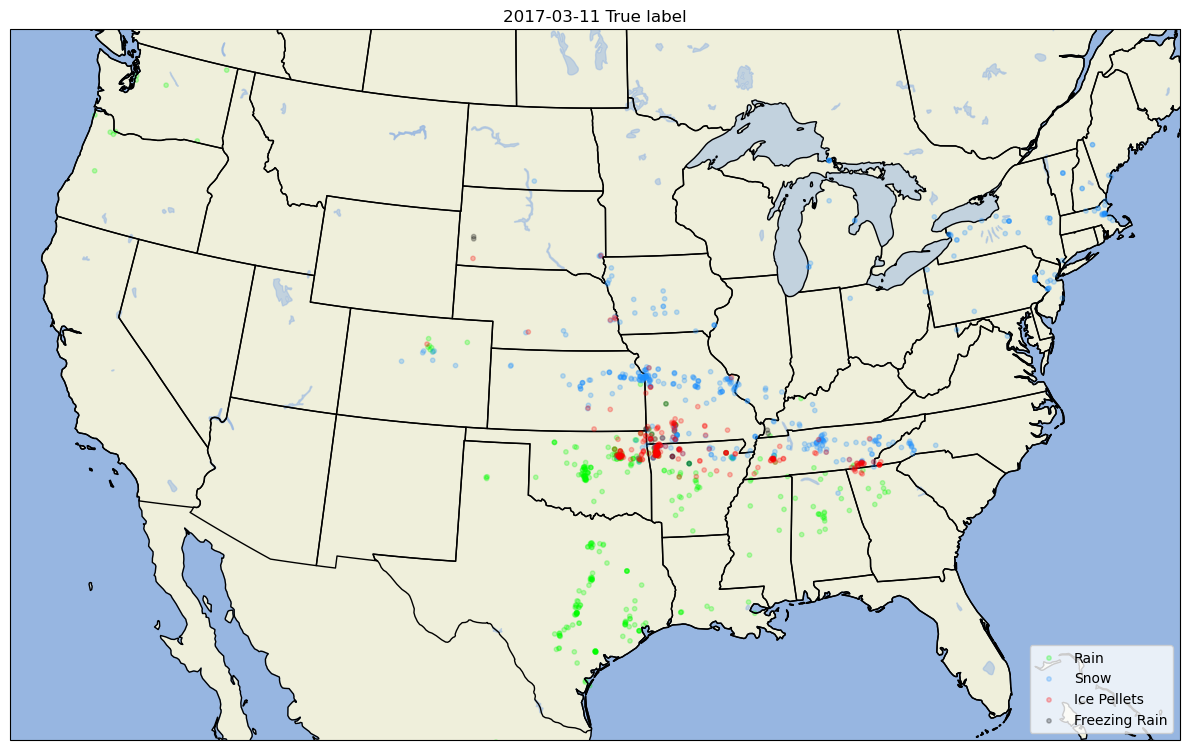

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some inpu

<Figure size 640x480 with 0 Axes>

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


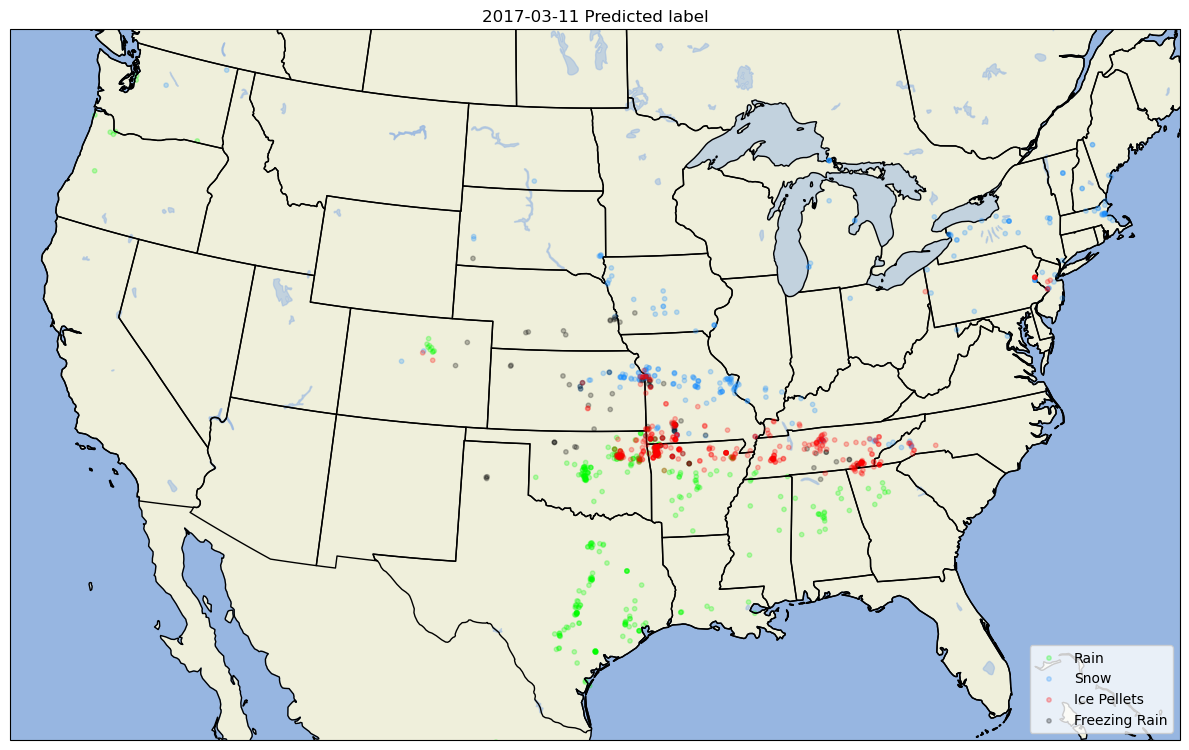

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some inpu

<Figure size 640x480 with 0 Axes>

In [78]:
labels_video(test_data, ne_noreaster, "mping", "true_label", "True label", "NorEaster") 
labels_video(test_data, ne_noreaster, "mping", "pred_label", "Predicted label", "NorEaster")

In [79]:
#video(test_data, ne_noreaster, "pred_conf", "Probability", "NorEaster")

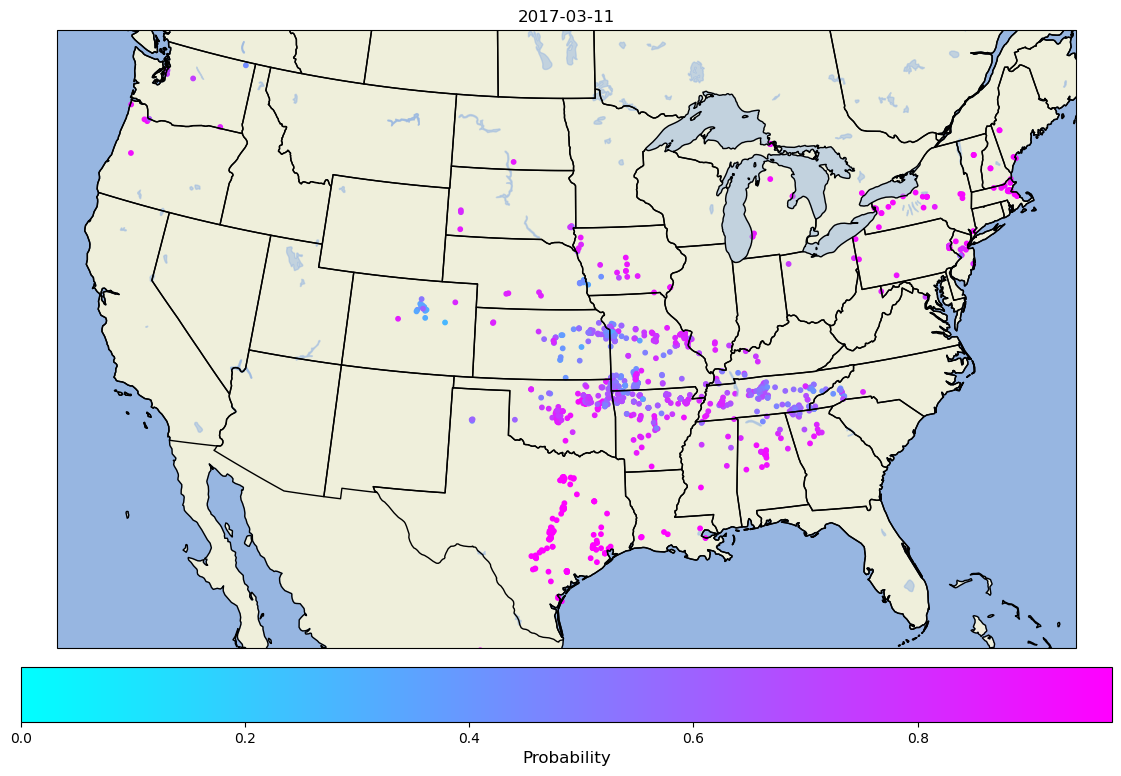

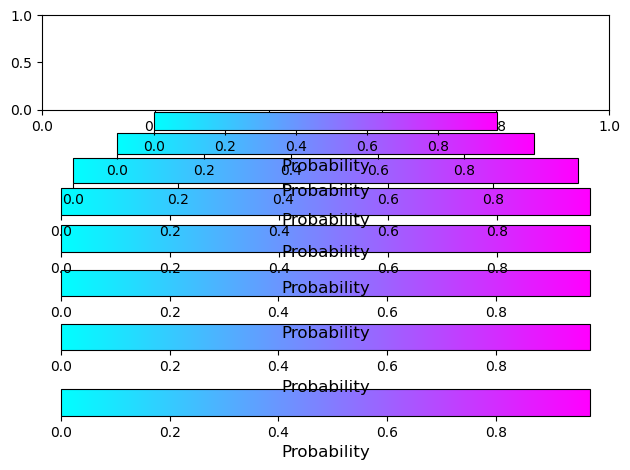

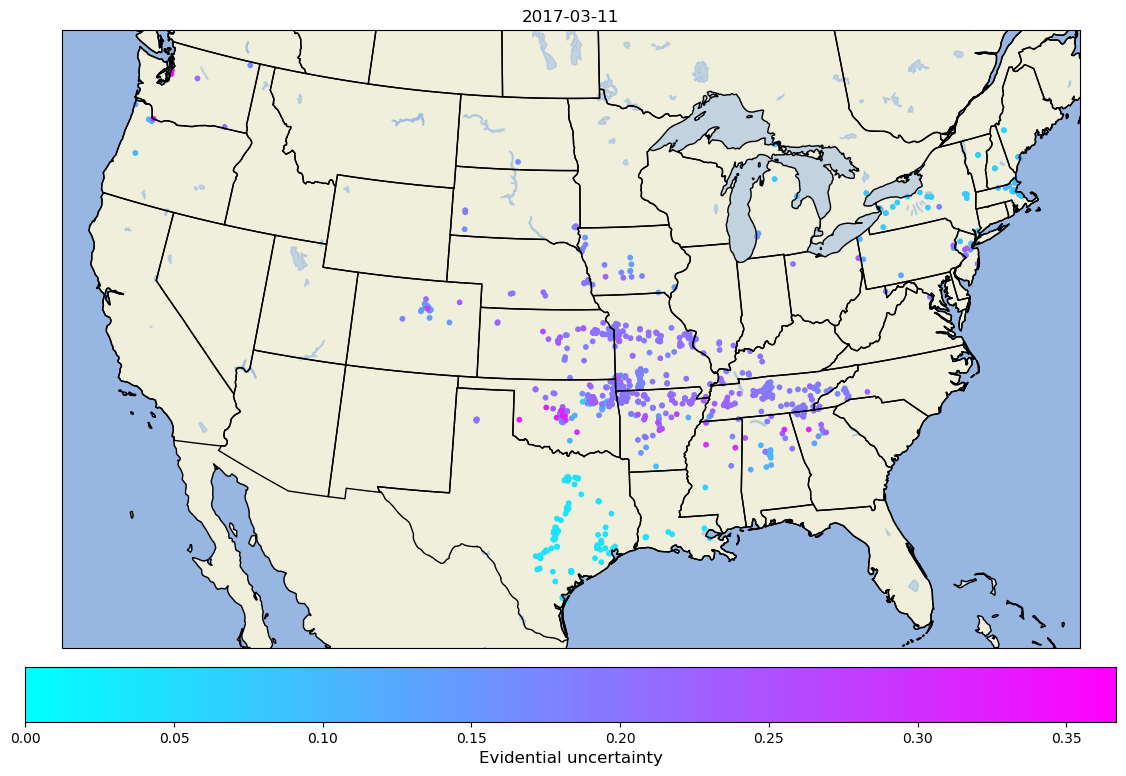

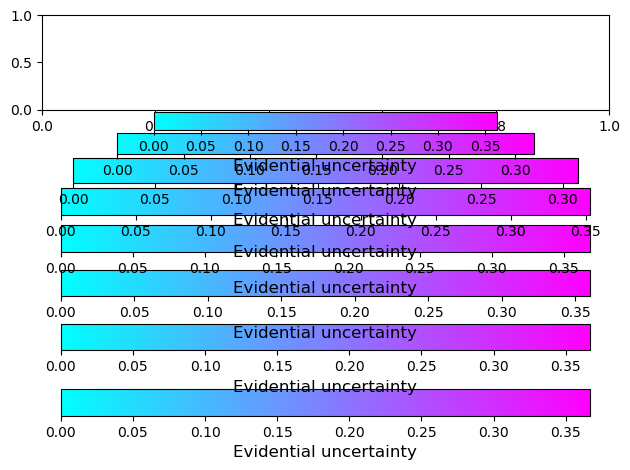

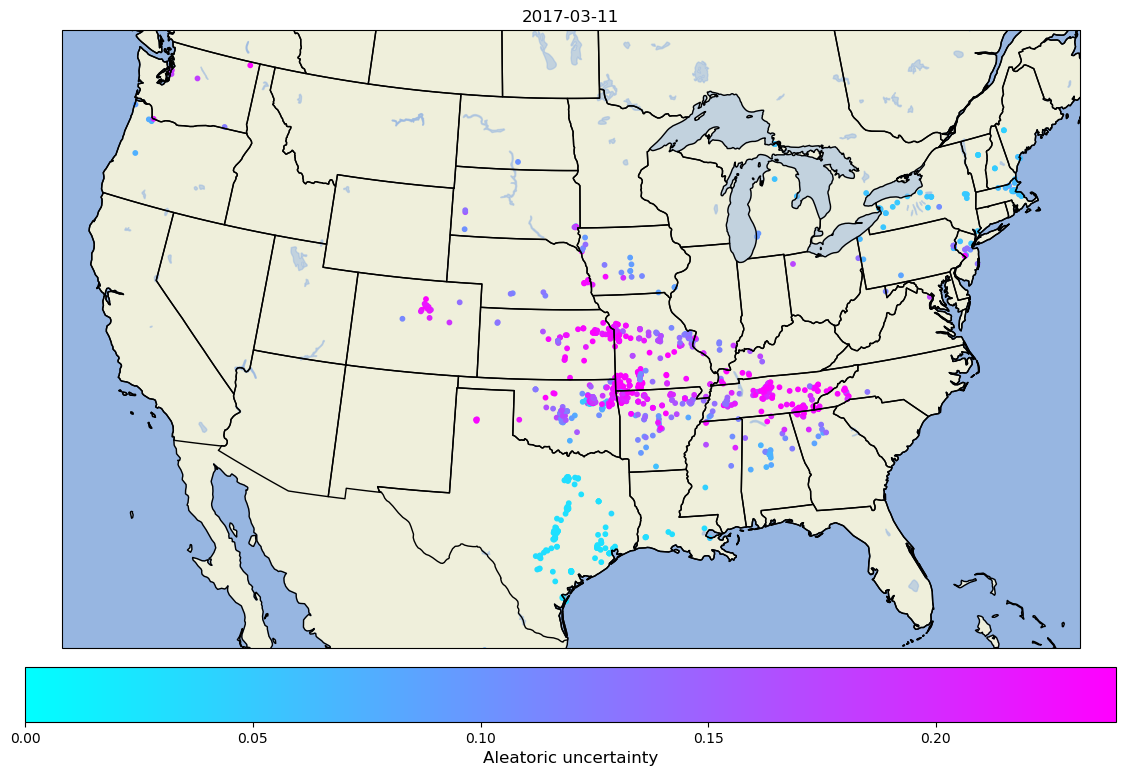

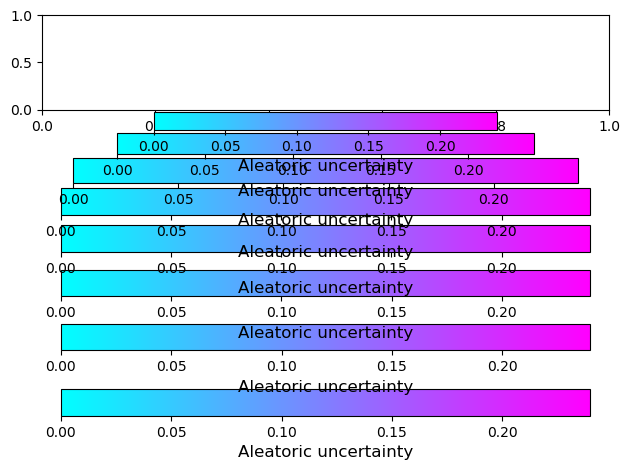

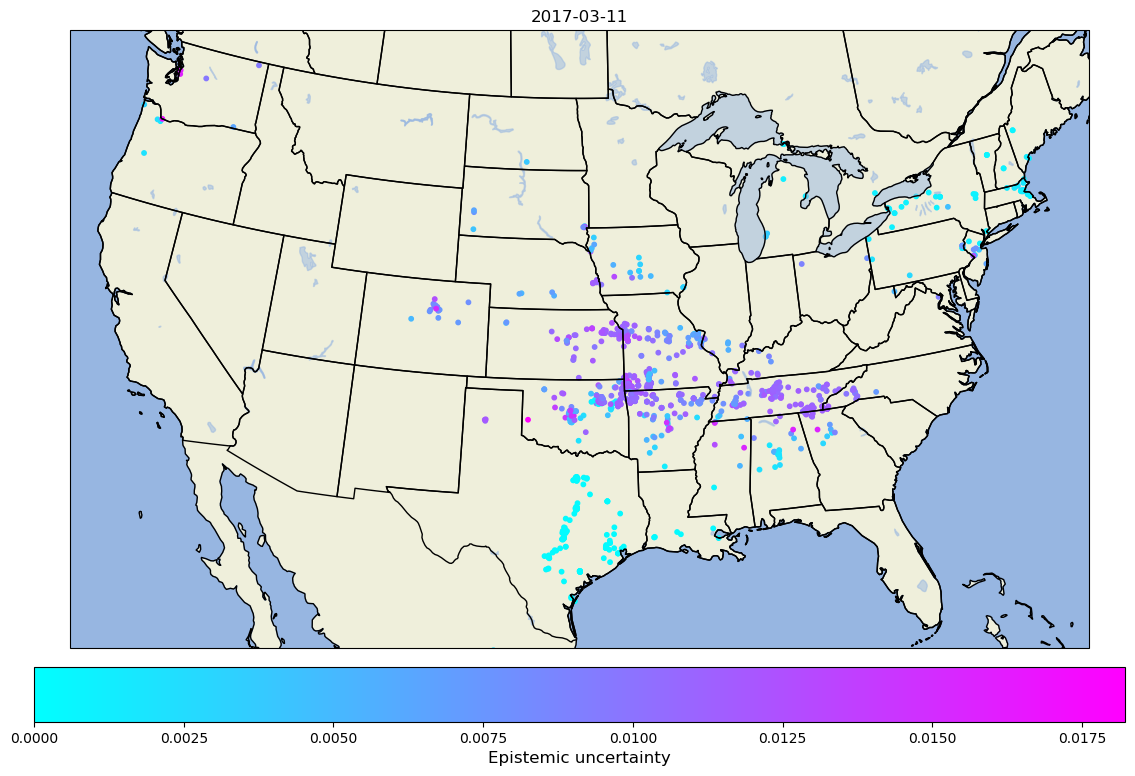

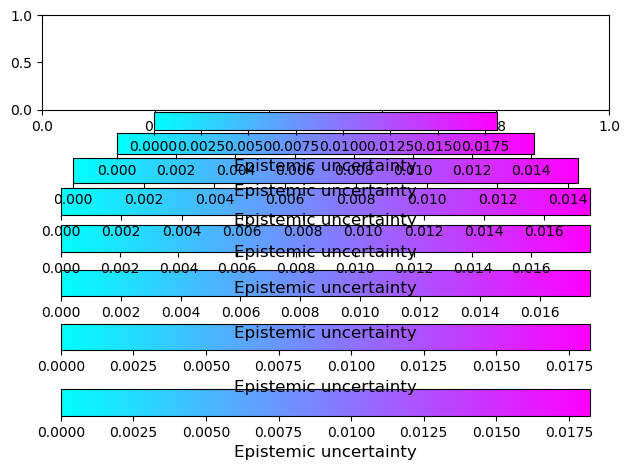

In [80]:
video(test_data, ne_noreaster, "pred_conf", "Probability", "NorEaster")
video(test_data, ne_noreaster, "pred_sigma", "Evidential uncertainty", "NorEaster")
video(test_data, ne_noreaster, "pred_ale", "Aleatoric uncertainty", "NorEaster")
video(test_data, ne_noreaster, "pred_epi", "Epistemic uncertainty", "NorEaster")

In [81]:
#CCC = (test_data["day"].isin(ne_noreaster[0:1]) & (test_data["true_label"] >= 0))

In [82]:
# conf_sigma_plots(test_data[CCC], 
#                  col = "pred_conf", 
#                  label = "Confidence")
# conf_sigma_plots(test_data[CCC], 
#                  col = "pred_sigma", 
#                  label = "Evidential uncertainty")

In [83]:
# conf_sigma_plots(test_data[CCC], 
# #                 col = "pred_ale", 
#                  label = "Aleatoric uncertainty")
# conf_sigma_plots(test_data[CCC], 
#                  col = "pred_epi", 
#                  label = "Epistemic uncertainty")

### December ice storm

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


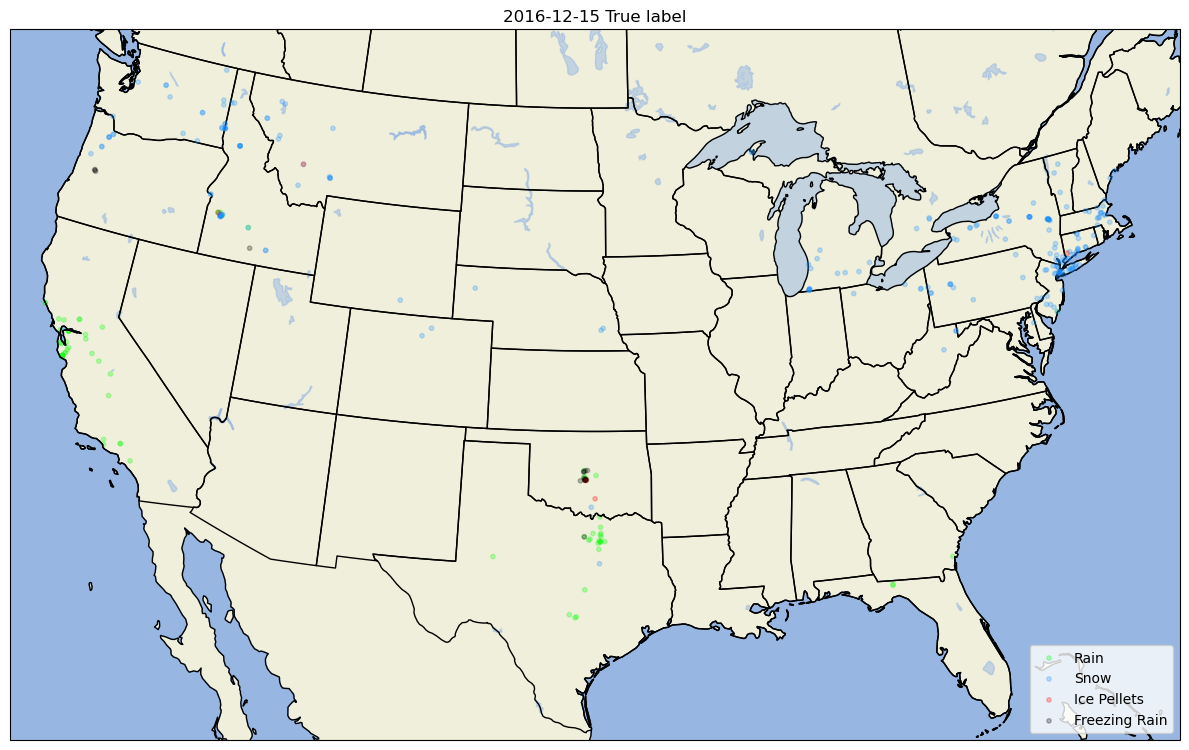

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some inpu

<Figure size 640x480 with 0 Axes>

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


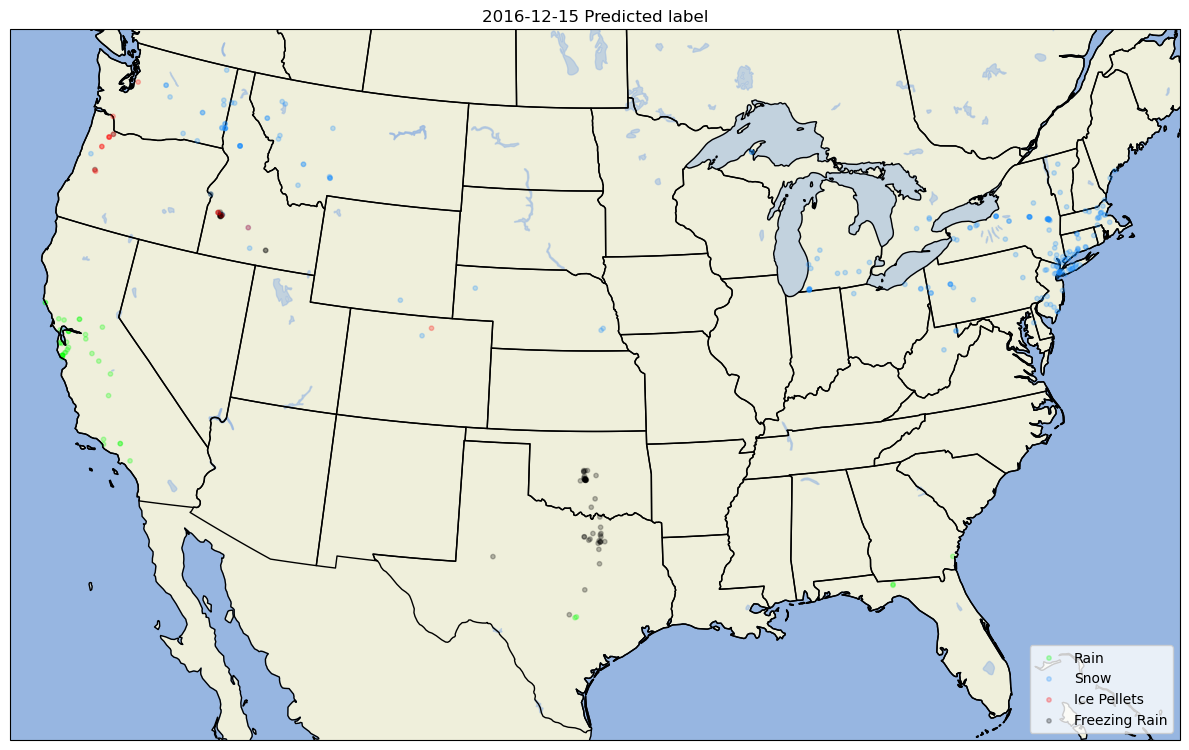

/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/glade/work/schreck/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: You have mixed positional and keyword arguments, some inpu

<Figure size 640x480 with 0 Axes>

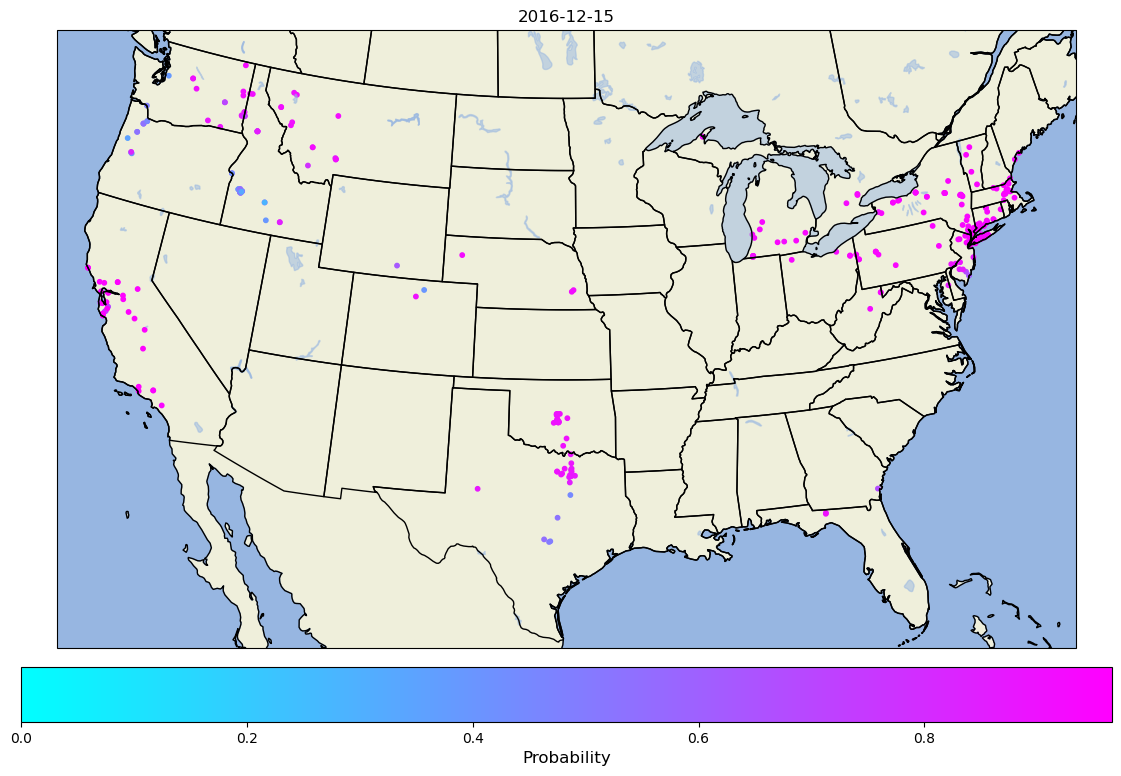

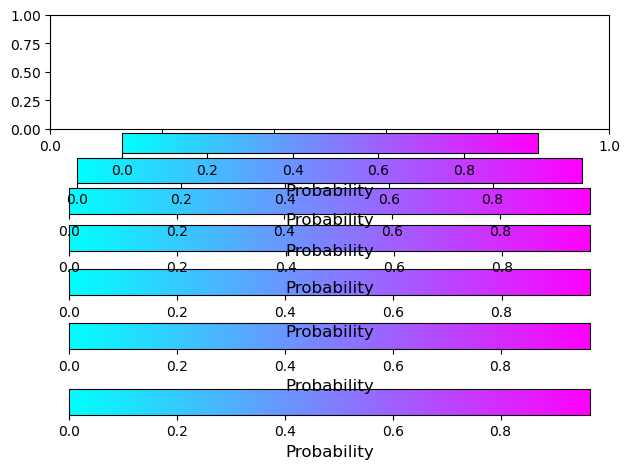

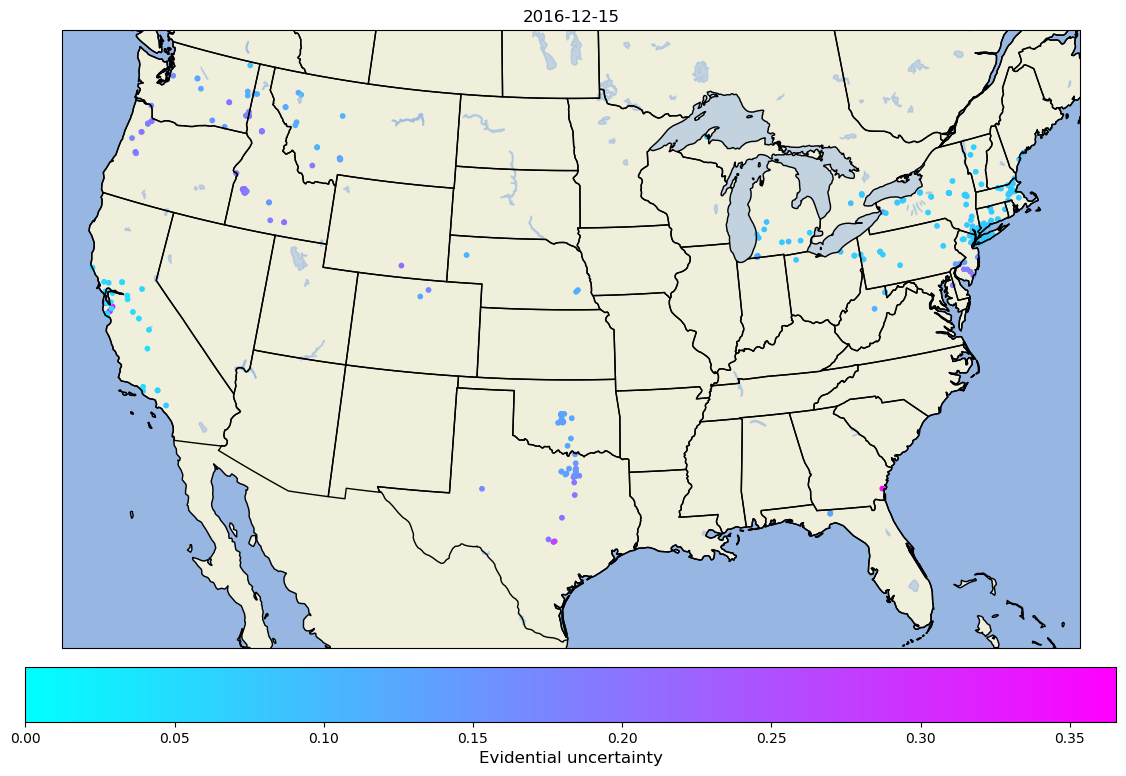

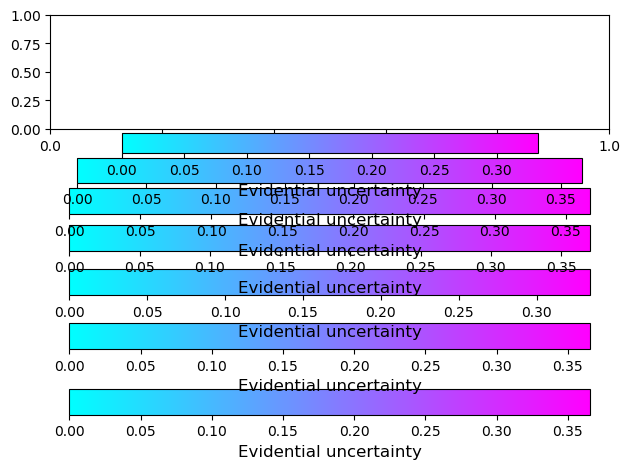

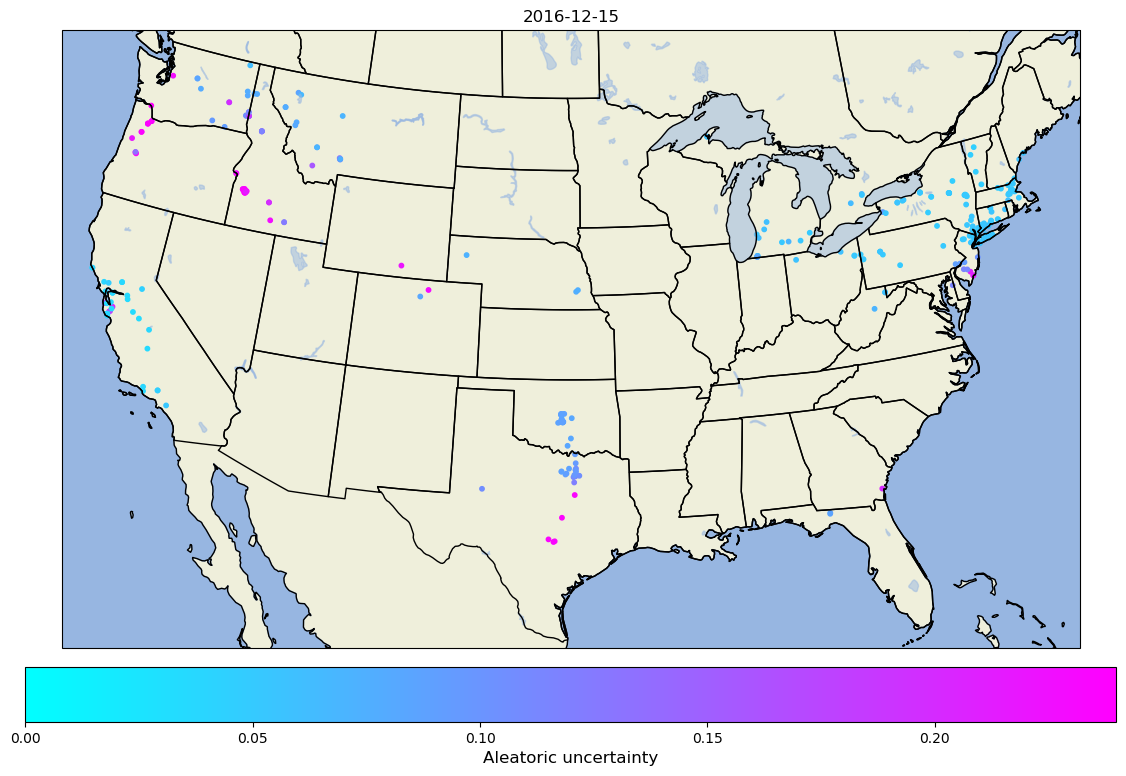

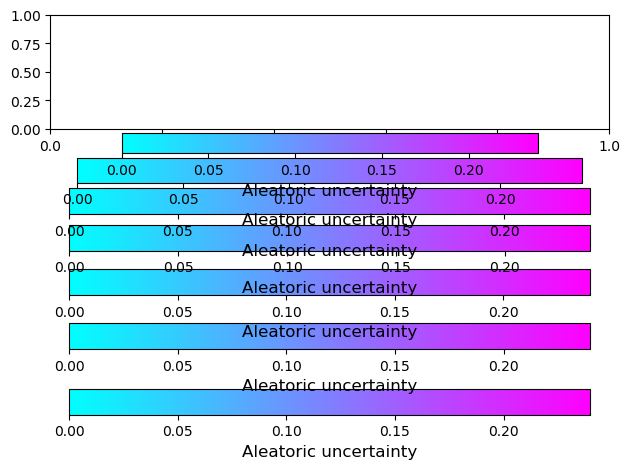

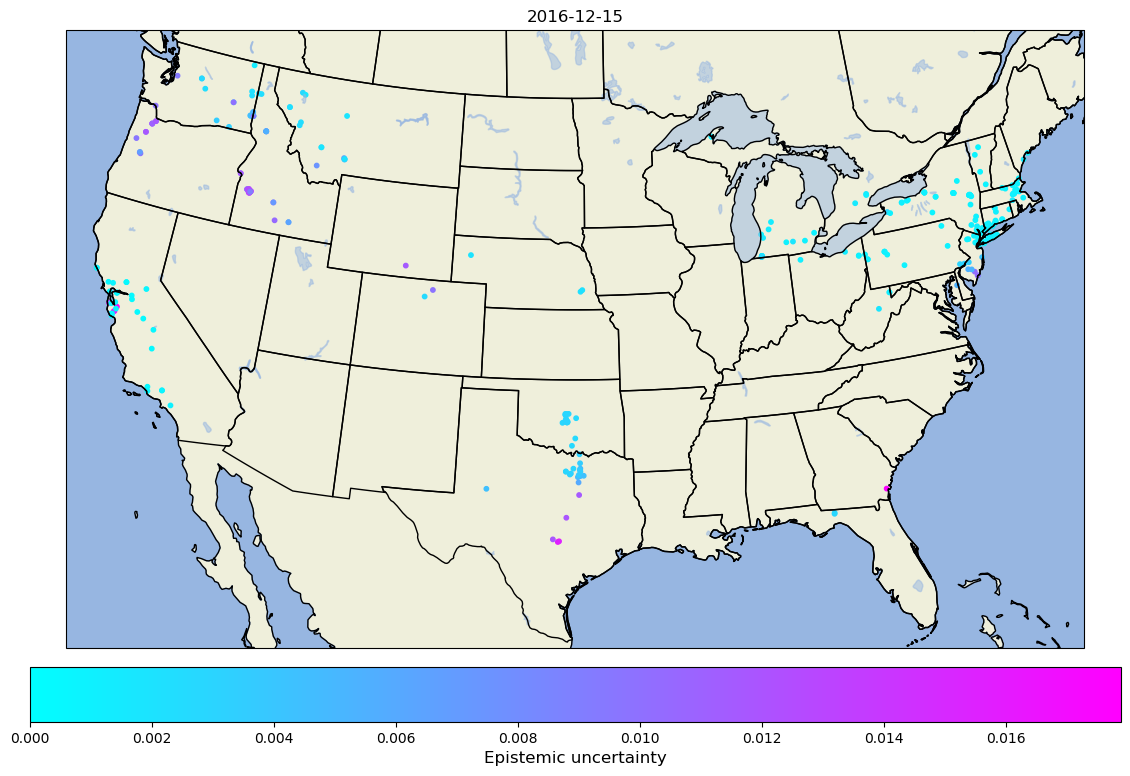

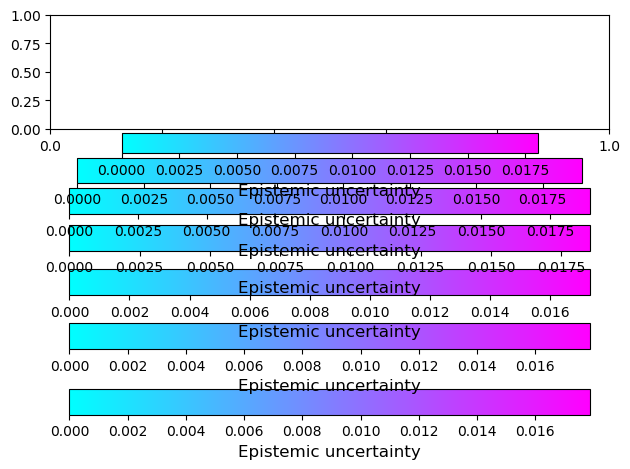

In [84]:
labels_video(test_data, dec_ice_storm, "mping", "true_label", "True label", "IceStorm") 
labels_video(test_data, dec_ice_storm, "mping", "pred_label", "Predicted label", "IceStorm")

video(test_data, dec_ice_storm, "pred_conf", "Probability", "IceStorm")
video(test_data, dec_ice_storm, "pred_sigma", "Evidential uncertainty", "IceStorm")
video(test_data, dec_ice_storm, "pred_ale", "Aleatoric uncertainty", "IceStorm")
video(test_data, dec_ice_storm, "pred_epi", "Epistemic uncertainty", "IceStorm")

/glade/work/schreck/py37/lib/python3.7/site-packages/evml/plotting.py:96: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


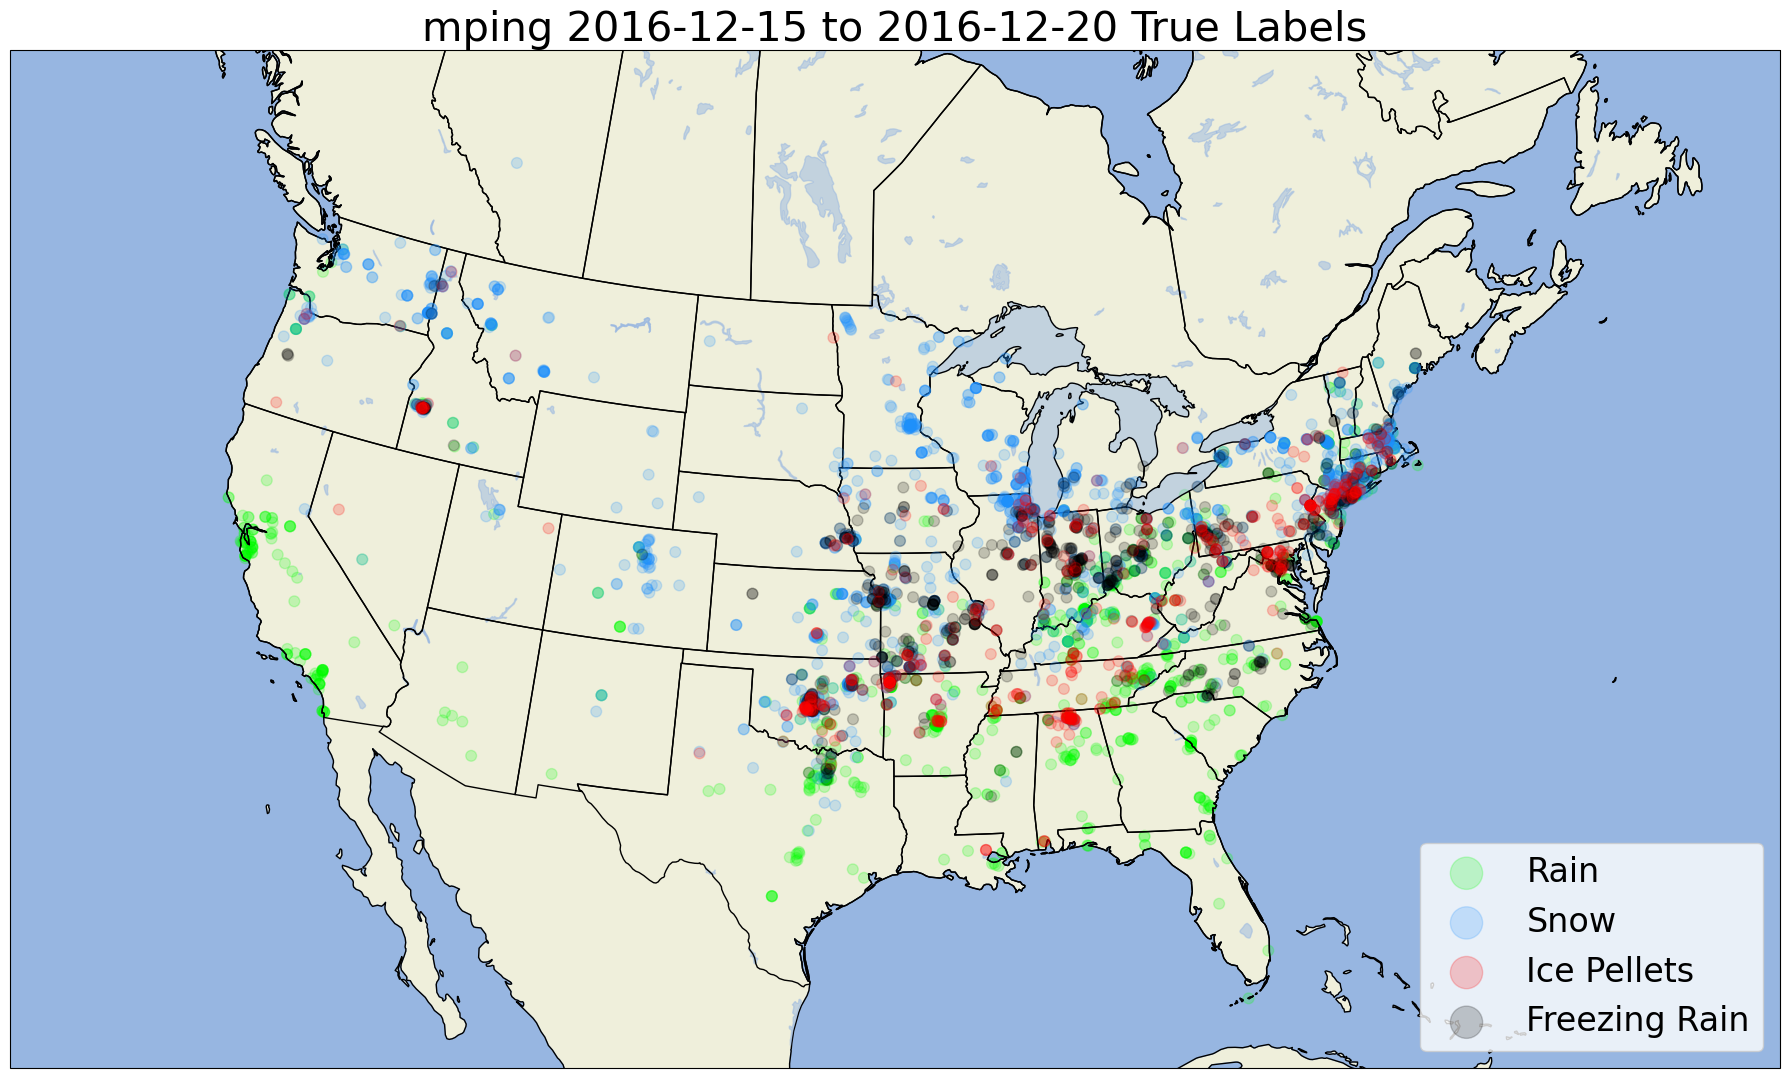

/glade/work/schreck/py37/lib/python3.7/site-packages/evml/plotting.py:96: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")


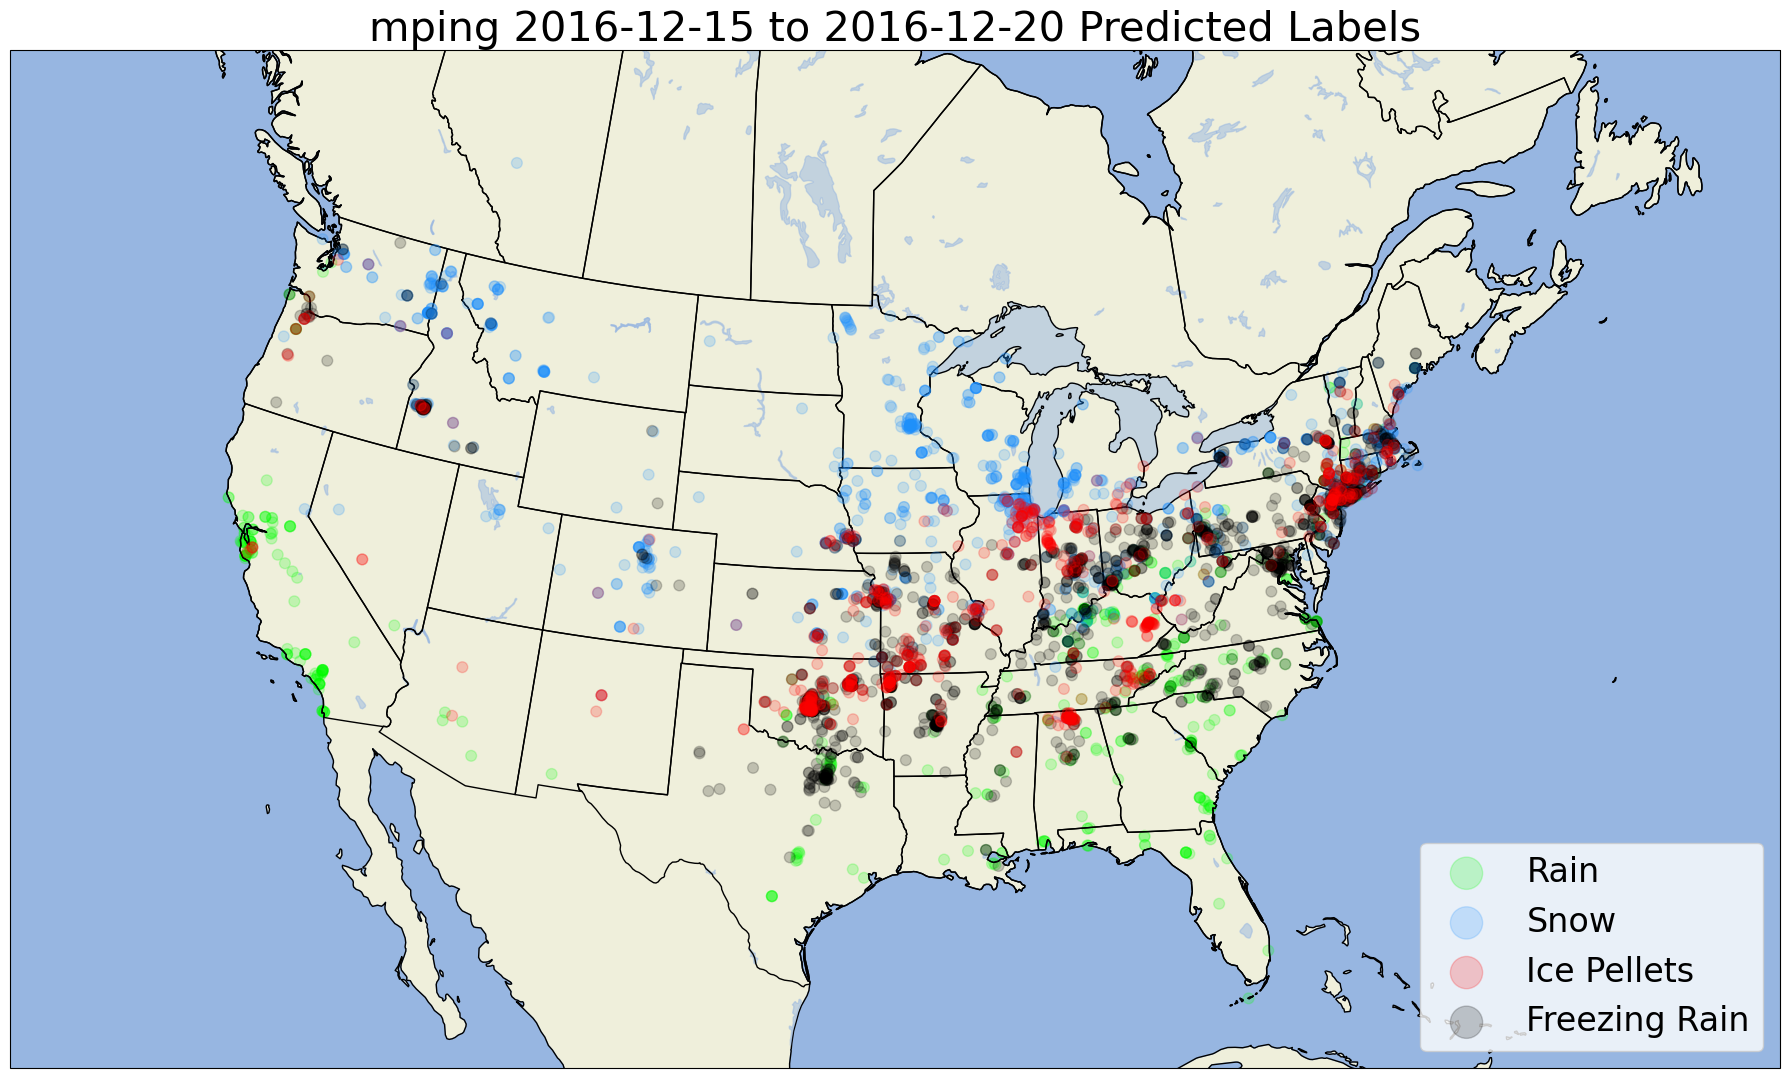

In [85]:
conus_plot(
    test_data[test_data["day"].isin(dec_ice_storm)], 
    column = 'true_label', 
    title = "True"
)

conus_plot(
    test_data[test_data["day"].isin(dec_ice_storm)], 
    column = 'pred_label', 
    title = "Predicted"
)